## AutoEncoder(ノイズ除去MNIST)

In [1]:
import tensorflow as tf
import keras

### データセットのダウンロード

In [3]:
#初期値設定
image_x ,image_y = 28, 28 #画像サイズ
batch_size = 128 #バッチサイズ
input_shape = (image_x, image_y, 1)
num = 10 #0~9番号
epochs = 5
Noise = 0.5

In [4]:
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()
#学習用データ60000個,テスト用データ10000個

In [5]:
#1次配列に変換
x_train = x_train.reshape(x_train.shape[0], image_x, image_y, 1)
x_test = x_test.reshape(x_test.shape[0], image_x, image_y, 1)

In [6]:
#0~1に正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### ノイズの付与

In [8]:
import numpy as np
noise = Noise

x_train_noise = x_train + noise * np.random.normal(loc=0., scale=1., size=x_train.shape) #正規分布乱数の付与
x_test_noise = x_test + noise * np.random.normal(loc=0., scale=1., size=x_test.shape)

x_train_noise = np.clip(x_train_noise, 0., 1.)
x_test_noise = np.clip(x_test_noise, 0., 1.)

### モデルの作成

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

In [10]:
model = Sequential()
model.add(Conv2D(32,                                   #filter:フィルタの個数
                kernel_size = 3,                   #2次元(3,3)畳み込みウィンドウの幅と高さ
                activation = 'relu',
                padding = 'same',                      #入出力のサイズを合わせる
                input_shape = input_shape))            #入力shape
model.add(MaxPooling2D(pool_size = (2, 2)))            #領域内で最大値をとるモデル
model.add(Conv2D(32, (3,3),
                 activation = 'relu',                  #relu:正規化線形関数
                 padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))            #領域内で最大値をとるモデル
model.add(Conv2D(32, (3,3),
                 activation = 'relu',                  #relu:正規化線形関数
                 padding = 'same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3),
                 activation = 'relu',                  #relu:正規化線形関数
                 padding = 'same'))
model.add(UpSampling2D((2, 2)))
#model.add(Dropout(0.25))
model.add(Conv2D(1, (3,3),
                 activation = 'sigmoid',               #sigmoid:S字型関数
                 padding = 'same'))
model.summary()

#損失関数・最適化関数、評価指数の指定とコンパイル
model.compile(loss = 'categorical_crossentropy', #損失関数 -> https://keras.io/objectives/
              optimizer = 'Adam', #評価関数 -> https://keras.io/optimizer/
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 32)       0

### モデルの学習

In [11]:
hist = model.fit(x_train_noise, x_train,
                batch_size = batch_size,
                epochs = epochs,
                shuffle = True,
                verbose = 1,
                validation_data = (x_test_noise, x_test)) #検証用データ

Epoch 1/5
469/469 [==============================] - 62s 132ms/step - loss: 0.0000e+00 - accuracy: 0.8081 - val_loss: 0.0000e+00 - val_accuracy: 0.8072
Epoch 2/5
469/469 [==============================] - 61s 131ms/step - loss: 0.0000e+00 - accuracy: 0.8088 - val_loss: 0.0000e+00 - val_accuracy: 0.8072
Epoch 3/5
469/469 [==============================] - 61s 129ms/step - loss: 0.0000e+00 - accuracy: 0.8088 - val_loss: 0.0000e+00 - val_accuracy: 0.8072
Epoch 4/5
469/469 [==============================] - 63s 134ms/step - loss: 0.0000e+00 - accuracy: 0.8088 - val_loss: 0.0000e+00 - val_accuracy: 0.8072
Epoch 5/5
469/469 [==============================] - 61s 130ms/step - loss: 0.0000e+00 - accuracy: 0.8088 - val_loss: 0.0000e+00 - val_accuracy: 0.8072


In [27]:
#モデルの評価
score = model.evaluate(x_test_noise, x_test)
print('Test loss:', score[0]) #損失
print('Test acc :', score[1]) #正解率

313/313 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8072
Test loss: 0.0
Test acc : 0.8072424530982971


313/313 [==============================] - 2s 7ms/step


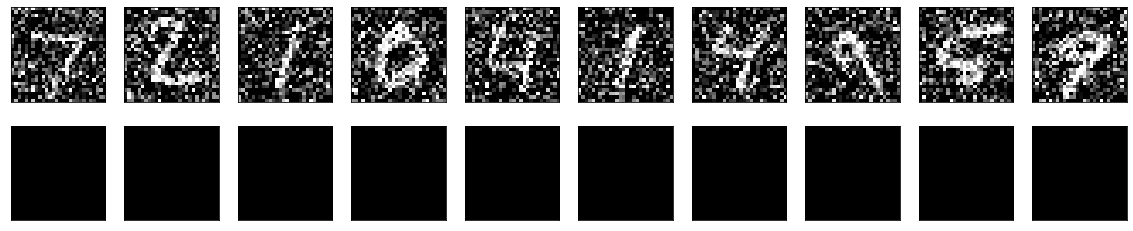

In [12]:
import matplotlib.pyplot as plt
n = 10
result = model.predict(x_test_noise)

fig = plt.figure(figsize = (20, 4))
for i in range(n):
    ax1 = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noise[i].reshape(image_x, image_y))
    plt.gray()
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    ax2 = plt.subplot(2, n, n+i+1)
    plt.imshow(result[i].reshape(image_x, image_y))
    plt.gray()
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
plt.show

fig.savefig("mnist_noise.png")